# Supervised Fine-Tuning (SFT) with LoRA/QLoRA using TRL — on a Free Colab Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/huggingface/cookbook/blob/main/notebooks/en/fine_tuning_llm_grpo_trl.ipynb)

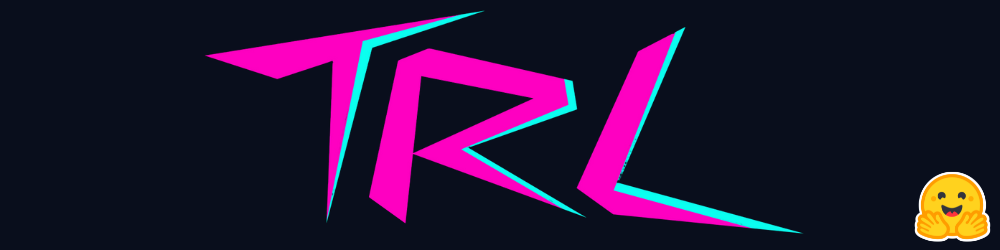

Easily fine-tune Large Language Models (LLMs) or Vision-Language Models (VLMs) with **LoRA** or **QLoRA** using the [**Transformers Reinforcement Learning (TRL)**](https://github.com/huggingface/trl) library built by Hugging Face — all within a **free Google Colab notebook** (powered by a **T4 GPU**.).  

- [TRL GitHub Repository](https://github.com/huggingface/trl) — star us to support the project!  
- [Official TRL Examples](https://huggingface.co/docs/trl/example_overview)  
- [Community Tutorials](https://huggingface.co/docs/trl/community_tutorials)

Learn how to perform **Supervised Fine-Tuning (SFT)** with **LoRA/QLoRA** using **TRL**.

## Install dependencies

We'll install **TRL**, which automatically includes the main dependencies such as **Transformers** and **PEFT**.
Additionally, we'll install **trackio** to log and monitor our experiments.

In [1]:
!pip install -Uq trl trackio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.7/865.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 11.9 MB/s eta 0:00:00


### Log in to Hugging Face

Log in to your **Hugging Face** account to save your fine-tuned model, track your experiment results directly on the Hub or access gated models. You can find your **access token** on your [account settings page](https://huggingface.co/settings/tokens).

You can skip this cell and the next if you don’t want to save your model, although doing so may lead to unexpected behavior.








In [ ]:
from huggingface_hub import notebook_login

notebook_login()

We’ll retrieve your **Hugging Face username** to use it as part of the path for saving and loading the fine-tuned model.

In [1]:
from huggingface_hub import HfApi

api = HfApi()
username = api.whoami()["name"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


If you're not logged in to Hugging Face, uncomment and run the cell below to avoid potential errors.

In [ ]:
# username = ""

## Load dataset

In this step, we load the **Capybara** dataset from the Hugging Face Hub using the `datasets` library.  
**Capybara** is a collection of high-quality, multi-turn synthetic conversations generated. It emphasizes reasoning, logic, and information diversity across a wide range of domains—making it ideal for training models capable of engaging in complex and natural dialogues.  

Here, we load only the **training split** for efficiency:

In [3]:
from datasets import load_dataset

dataset_name = "trl-lib/Capybara"
train_dataset = load_dataset(dataset_name, split = "train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


README.md:   0%|          | 0.00/520 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/37.2M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/482k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15806 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

## Load model and configure LoRA/QLoRA

There are two ways to use this notebook, depending on your chosen fine-tuning method:

- **Using QLoRA:** Run the following cell as is.  
- **Using LoRA:** Comment out the installation instruction and update the `use_qlora` parameter accordingly.

In [4]:
# If using QLoRA
!pip install -Uq bitsandbytes

use_qlora = True
# use_qlora = False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 10.4 MB/s eta 0:00:00


Below, choose your **preferred model**. All of the options have been tested on **free Colab instances**.

In [2]:
# --- 🔧 Model selection ---

# Select one model below by uncommenting the line you want to use 👇
# (Comments indicate memory usage or warnings)

# 🧠 LoRA models (explicitly LoRA)
## Qwen QLoRA
model_id, output_dir = "Qwen/Qwen3-0.6B", "Qwen3-0.6B-SFT"        # ✅ WORKS
model_id, output_dir = "Qwen/Qwen3-1.7B", "Qwen3-1.7B-SFT"        # ✅ WORKS

# 🧩 QLoRA models (default if not LoRA)
## Qwen QLoRA
# model_id, output_dir = "Qwen/Qwen2.5-0.5B-Instruct", "Qwen2.5-0.5B-Instruct"
# model_id, output_dir = "Qwen/Qwen3-4B", "Qwen3-4B-SFT"            # ✅ WORKS
# model_id, output_dir = "Qwen/Qwen3-8B", "Qwen3-8B-SFT"            # ⚠️ ~12.8 GB VRAM
# model_id, output_dir = "Qwen/Qwen3-14B", "Qwen3-14B-SFT"          # ❌ OOM


## LLaMA QLoRA
# model_id, output_dir = "meta-llama/Llama-3.1-8B-Instruct", "Llama-3.1-8B-Instruct"  # ⚠️ ~10.9 GB VRAM
# model_id, output_dir = "meta-llama/Llama-3.2-3B-Instruct", "Llama-3.2-3B-Instruct"  # ✅ ~4.7 GB VRAM

## DeepSeek QLoRA
# model_id, output_dir = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B", "DeepSeek-R1-0528-Qwen3-8B"

## Gemma QLoRA
# model_id, output_dir = "google/gemma-3n-E2B-it", "gemma-3n-E2B-it"  # ❌ OOM
# model_id, output_dir = "google/gemma-3-4b-it", "gemma-3-4b-it"      # ⚠️ image processing error

## Granite QLoRA
#model_id, output_dir = "ibm-granite/granite-4.0-micro", "granite-4.0-micro"  # ✅ ~3.3 GB VRAM

Let's lead the selected model using `transformers`, configuring QLoRA via `bitsandbytes` if needed. We don't need to configure the tokenizer since the trainer takes care of that automatically.

In [6]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

kwargs = {
    "attn_implementation": "sdpa",  # Change to Flash Attention if GPU has support
    "dtype": torch.float16,          # Change to bfloat16 if GPU has support
    "use_cache": True,
    "max_length": 2048,
}

if use_qlora:
    kwargs["quantization_config"] = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )

model = AutoModelForCausalLM.from_pretrained(model_id, **kwargs)

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The following cell defines LoRA (or QLoRA if needed).

In [7]:
from peft import LoraConfig

peft_config = LoraConfig(
    r=32,
    lora_alpha=16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
)

## Train model

Let's configure SFT using `SFTConfig`. We keep the parameters minimal to fit in a free Colab instance. You can play with them if more resources are available.

In [8]:
from trl import SFTConfig

training_args = SFTConfig(
    learning_rate=2e-4,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_steps=5,
    gradient_checkpointing=True,
    max_steps=2,
    logging_steps=1,

    optim="adamw_8bit" if use_qlora else "adamw_torch",

    report_to="trackio",

    output_dir=output_dir,
)

Configure the SFT Trainer. We pass the previously configured `training_args`. We don't use eval dataset to mantain memory usage low but you can configure it.

In [9]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=None,
    peft_config=peft_config
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Tokenizing train dataset:   0%|          | 0/15806 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/15806 [00:00<?, ? examples/s]

Show memory stats before training

In [10]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
3.346 GB of memory reserved.


And train!

In [11]:
trainer_stats = trainer.train()

* Running on public URL: https://4be1033b8b260efa7c.gradio.live
* Trackio project initialized: huggingface
* Trackio metrics logged to: /root/.cache/huggingface/trackio


* Created new run: dainty-sunset-0


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
1,2.157700
2,1.867100


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


* Run finished. Uploading logs to Trackio (please wait...)


Show memory stats after training

In [12]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

326.89 seconds used for training.
5.45 minutes used for training.
Peak reserved memory = 6.529 GB.
Peak reserved memory for training = 3.183 GB.
Peak reserved memory % of max memory = 44.291 %.
Peak reserved memory for training % of max memory = 21.593 %.


## Saving fine tuned model

In this step, we save the fine-tuned model both **locally** and to the **Hugging Face Hub** using the credentials from your account.

In [16]:
trainer.save_model(output_dir)
trainer.push_to_hub(f"{username}/{output_dir}", dataset_name=dataset_name)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   1%|1         | 1.14MB / 83.9MB            

  ...0-micro/training_args.bin:   3%|3         |   208B / 6.16kB            

CommitInfo(commit_url='https://huggingface.co/sergiopaniego/granite-4.0-micro/commit/e0805fd7d2398694350e585a87e5e7ce76b8e6f5', commit_message='sergiopaniego/granite-4.0-micro', commit_description='', oid='e0805fd7d2398694350e585a87e5e7ce76b8e6f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergiopaniego/granite-4.0-micro', endpoint='https://huggingface.co', repo_type='model', repo_id='sergiopaniego/granite-4.0-micro'), pr_revision=None, pr_num=None)

## Load fine-tuned model and run inference

Now, let's test the fine-tuned model by loading the **LoRA/QLoRA adapter** and performing **inference**.

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

base_model = model_id
adapter_model = f"{username}/{output_dir}" # if LoRA/QLoRA

model = AutoModelForCausalLM.from_pretrained(base_model, dtype="auto", device_map="auto")
model = PeftModel.from_pretrained(model, adapter_model) # if LoRA/QLoRA

tokenizer = AutoTokenizer.from_pretrained(base_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/927 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/140M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [4]:
messages = [
  {
    "role": "user",
    "content": "What is the capital of Spain?",
  },
]

In [5]:
text = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=500
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

# Decode and extract model response
generated_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(generated_text)

<think>
Okay, the user is asking for the capital of Spain. I need to make sure I get this right. Let me think... Spain is a country in Europe, right? I remember that Madrid is the capital. But wait, sometimes people get confused with other countries. For example, France's capital is Paris, and Germany's is Berlin. So Spain's capital should be Madrid. But maybe I should double-check to be sure. I can recall that the Spanish Constitution was established in 1978, and Madrid has been the capital since 1561. Yeah, that's correct. I don't think there's any other major city that's the capital. So the answer should be Madrid.
</think>

The capital of Spain is **Madrid**. It is the largest city in the country and the political, economic, and cultural center of Spain. Madrid was established in 1561 and has been the capital since then.


## Inference and Serving with vLLM

You can use Transformer models with **vLLM** to serve them in real-world applications. Learn more [here](https://blog.vllm.ai/2025/04/11/transformers-backend.html).

In [ ]:
!pip install -qU vllm

### Push Merged Model (for LoRA or QLoRA Training)

To serve the model via **vLLM**, the repository must contain the merged model (base model + LoRA adapter). Therefore, you need to upload it first.

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

model_merged = model.merge_and_unload()

save_dir = f"{output_dir}-merged"

model_merged.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('Qwen3-1.7B-SFT-merged/tokenizer_config.json',
 'Qwen3-1.7B-SFT-merged/special_tokens_map.json',
 'Qwen3-1.7B-SFT-merged/chat_template.jinja',
 'Qwen3-1.7B-SFT-merged/vocab.json',
 'Qwen3-1.7B-SFT-merged/merges.txt',
 'Qwen3-1.7B-SFT-merged/added_tokens.json',
 'Qwen3-1.7B-SFT-merged/tokenizer.json')

In [7]:
model_merged.push_to_hub(f"{username}/{output_dir}-merged")
tokenizer.push_to_hub(f"{username}/{output_dir}-merged")

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...-merged/model.safetensors:   1%|          | 33.5MB / 3.44GB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...SFT-merged/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/sergiopaniego/Qwen3-1.7B-SFT-merged/commit/e0049e80f76936572ff4b93478d36d7e6d5e6aa8', commit_message='Upload tokenizer', commit_description='', oid='e0049e80f76936572ff4b93478d36d7e6d5e6aa8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergiopaniego/Qwen3-1.7B-SFT-merged', endpoint='https://huggingface.co', repo_type='model', repo_id='sergiopaniego/Qwen3-1.7B-SFT-merged'), pr_revision=None, pr_num=None)

### Performing Inference with vLLM

Use **vLLM** to run your model and generate text efficiently in real-time. This allows you to test and deploy your fine-tuned models with low latency and high throughput.

In [8]:
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

llm = LLM(model=f"{username}/{output_dir}-merged", model_impl="transformers") # if LoRA/QLoRA
hf_tokenizer = AutoTokenizer.from_pretrained(f"{username}/{output_dir}-merged") # if LoRA/QLoRA

messages = [
  {
    "role": "user",
    "content": "What is the capital of Spain?",
  },
]

prompt = hf_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

outputs = llm.generate(
    {
        "prompt": prompt,
    },
    sampling_params=SamplingParams(max_tokens=500)
)

for o in outputs:
    generated_text = o.outputs[0].text
    print(generated_text)

INFO 10-09 15:11:00 [__init__.py:216] Automatically detected platform cuda.
INFO 10-09 15:11:04 [utils.py:233] non-default args: {'disable_log_stats': True, 'model_impl': 'transformers', 'model': 'sergiopaniego/Qwen3-1.7B-SFT-merged'}


config.json: 0.00B [00:00, ?B/s]

INFO 10-09 15:11:30 [model.py:547] Resolved architecture: TransformersForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


WARNING 10-09 15:11:30 [model.py:1682] Your device 'Tesla T4' (with compute capability 7.5) doesn't support torch.bfloat16. Falling back to torch.float16 for compatibility.
WARNING 10-09 15:11:30 [model.py:1733] Casting torch.bfloat16 to torch.float16.
INFO 10-09 15:11:30 [model.py:1510] Using max model len 40960
INFO 10-09 15:11:33 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

WARNING 10-09 15:11:39 [__init__.py:3036] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized


RuntimeError: Engine core initialization failed. See root cause above. Failed core proc(s): {}